# Introduction

## **LeNet-5**

LeNet is a convolutional neural network structure proposed by Yann LeCun et al. in 1989. In general, LeNet refers to LeNet-5 and is a simple convolutional neural network. LeNet-5 was one of the earliest convolutional neural networks and promoted the development of deep learning. Since 1988, after years of research and many successful iterations, the pioneering work has been named LeNet-5... [Read More](https://en.wikipedia.org/wiki/LeNet)

### Original Paper

Titled: **Gradient-Based Learning Applied to Document Recognition** 

Paper Link: [http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)

### Architecture

![LeNet-5 Architecture](https://www.researchgate.net/profile/Vina-Ayumi/publication/308788359/figure/fig1/AS:412924624556032@1475460310318/Architecture-of-CNN-by-LeCun-et-al-LeNet5.png)

___

## **CIFAR10 Dataset**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. [Read More](https://www.cs.toronto.edu/~kriz/cifar.html)

### The ten classes are:
- airplane
- automobile
- bird 
- cat 
- deer 
- dog 
- frog 
- horse
- ship
- truck

We'll be using Pytorch Image Datasets to get CIFAR10.
___

In [1]:
# imports

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import gc

### **Transforms**

In [2]:
train_augmentations = transforms.Compose([transforms.RandomGrayscale(0.2),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomVerticalFlip(0.2),
                                          transforms.RandomRotation(30),
                                          transforms.RandomAdjustSharpness(0.4),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )

### **Dataset from torchvision**

In [3]:
path = '/tmp'

train_ds = datasets.CIFAR10(root=path,
                            train=True,
                            transform=train_augmentations,
                            download=True
                           )

test_ds = datasets.CIFAR10(root=path,
                           train=False,
                           transform=test_augmentations
                           )

labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()

Files already downloaded and verified


In [4]:
len(train_ds), len(test_ds)

(50000, 10000)

### **Visualization of CIFAR10**

#### Train Dataset after augmentations

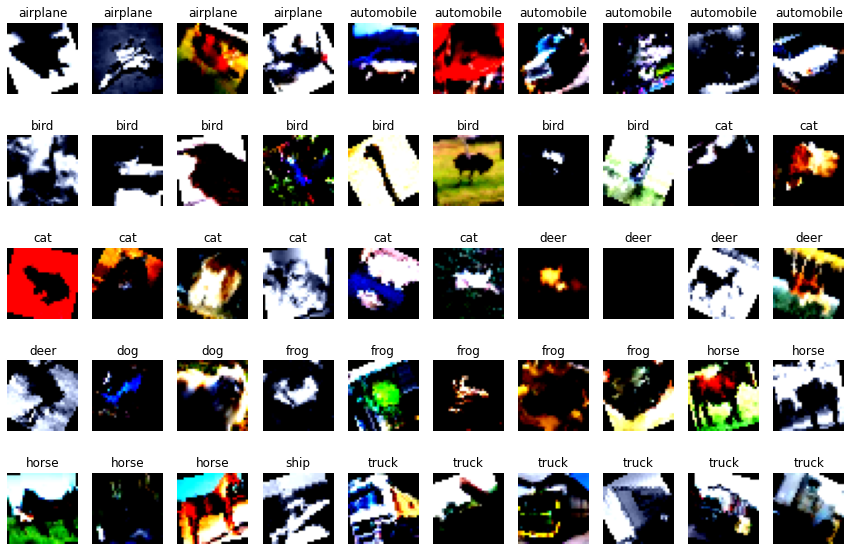

In [5]:
first_50_samples = sorted([train_ds[i] for i in range(50)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,51):
    img = first_50_samples[i-1][0].permute(1,2,0)
    label = labels[first_50_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

___

### **Dataloaders**

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=True, num_workers=2)

# ![PyTorch](https://img.shields.io/badge/PyTorch-%23EE4C2C.svg?style=for-the-badge&logo=PyTorch&logoColor=white) **CNN Model: LeNet-5**

In [7]:
class LeNet(nn.Module):
    
    def __init__(self, in_features=3, num_classes=10):
        super(LeNet, self).__init__()
        
        self.conv_block = nn.Sequential( nn.Conv2d(in_channels=in_features,
                                                   out_channels=6,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2,2),
                                         
                                         nn.Conv2d(in_channels=6,
                                                   out_channels=16,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.Tanh(),
                                         nn.MaxPool2d(2,2)
                                        )
        
        self.linear_block = nn.Sequential( nn.Linear(16*5*5, 120),
                                           nn.Tanh(),
                                           nn.Linear(120,84),
                                           nn.Tanh(),
                                           nn.Linear(84,10)
                                         )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [8]:
# CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [10]:
class Trainer:
    def __init__(self, model, dataloaders, device):
        
        self.config = {
            'lr':1e-3,
            'epochs': 10
        }
        
        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.model.parameters(), lr = self.config['lr'])
        self.device = device
        
    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)
        
    def train_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for x,y in self.train_loader:
            
            self.optim.zero_grad()
            
            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)
            
            output = self.model(x)
            
            loss = self.loss_fn(output, y)
            
            loss.backward()
            self.optim.step()
            
            running_loss += loss.item()
            running_acc += self.accuracy(output,y)
            
            del x,y,output
            
        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)
        
        return train_loss, train_acc
    
    @torch.no_grad()
    def valid_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for x,y in self.valid_loader:
            
            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)
            
            output = self.model(x)
            
            loss = self.loss_fn(output, y)
            
            running_loss += loss.item()
            running_acc += self.accuracy(output,y)
            
            del x,y,output
            
        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)
        
        return valid_loss, valid_acc
    
    
    def fit(self):
        
        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []
        
        for epoch in range(self.config['epochs']):
            
            print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")
            
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            self.model.eval()
            
            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            
            print(f"------EPOCH {epoch+1}/{self.config['epochs']}------")
            print(f"Training: LOSS: {train_loss} | ACCURACY: {train_acc}")
            print(f"Validation: LOSS: {valid_loss} | ACCURACY: {valid_acc}\n\n")
            
            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()
            
        
        return (train_losses, train_accs), (valid_losses, valid_accs)
            
        
        

In [11]:
trainer = Trainer(model, (train_dataloader, valid_dataloader), device)

(train_losses, train_accs), (valid_losses, valid_accs) = trainer.fit()

Model is using cuda
------EPOCH 1/10------
Training: LOSS: 1.8846216688350754 | ACCURACY: 0.32140066964285713
Validation: LOSS: 1.5915252327919007 | ACCURACY: 0.43076171875


Model is using cuda
------EPOCH 2/10------
Training: LOSS: 1.661689213344029 | ACCURACY: 0.39820232780612247
Validation: LOSS: 1.4293766379356385 | ACCURACY: 0.4806640625


Model is using cuda
------EPOCH 3/10------
Training: LOSS: 1.5584485518689057 | ACCURACY: 0.43774713010204086
Validation: LOSS: 1.379328864812851 | ACCURACY: 0.5080078125


Model is using cuda
------EPOCH 4/10------
Training: LOSS: 1.5056825383585326 | ACCURACY: 0.4571906887755102
Validation: LOSS: 1.3021482229232788 | ACCURACY: 0.53173828125


Model is using cuda
------EPOCH 5/10------
Training: LOSS: 1.4636319583776045 | ACCURACY: 0.47401945153061226
Validation: LOSS: 1.296656334400177 | ACCURACY: 0.52685546875


Model is using cuda
------EPOCH 6/10------
Training: LOSS: 1.4309434014923719 | ACCURACY: 0.48618861607142855
Validation: LOSS: 1.2

### **Graphs**

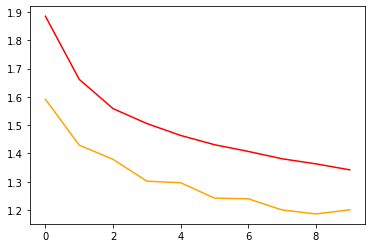

In [13]:
plt.plot(train_losses, color='red')
plt.plot(valid_losses, color='orange')

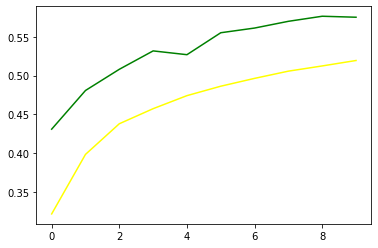

In [14]:
plt.plot(train_accs, color='yellow')
plt.plot(valid_accs, color='green')

#### **Thoughts**

- LeNet-5 was mainly used for document recognition, one of the first proper CNN Models, CIFAR10 is a vast dataset so I'm not sure if the model is a good fit for the dataset but performed decent nonetheless for only 10 epochs.

- In the latter models, ReLU activation had become more popular instead on TanH which reduced the error and makes better sense for image models afaik.

- It was a good experience for me to figure out the model implementation from the paper directly, I did google some stuff, many implementations I found were not using tanh activation but sigmoid/relu instead, paper mentions tanh as the squashing function used.

- Although the accuracy seems underwhelming, I enjoyed the process overall!

Would love to see feedback on this notebook!
Thank you for taking the time to go through this :)

### 